# 导入必要的库

In [1]:
import os
import sys
import json

import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F

from PIL import Image
import random

from MedMamba import VSSM as medmamba # import model

import utils
from config import Config

import matplotlib.pyplot as plt

# 载入模型

In [2]:
%%capture
net = medmamba(num_classes=Config.NUM_CLASS)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_weight_path = "./Net.pth"
assert os.path.exists(model_weight_path), "cannot find {} file".format(model_weight_path)
net.load_state_dict(torch.load(model_weight_path, map_location=device))
net.to(device)

# 指定推理图片目录，选择一张COVID的X光图片

In [3]:
# 1. 指定图片文件夹路径
image_folder = "data/CPN Chest X-Ray Images/COVID"
assert os.path.exists(image_folder), "Cannot find {} folder".format(image_folder)

# 从指定文件夹中随机选择一张图片

In [8]:
# 2. 随机选择一张图片
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
random_image_file = random.choice(image_files)
image_path = os.path.join(image_folder, random_image_file)

# 将该图片输入模型并展示预测结果

Class 0: COVID - 99.66%
Class 1: NORMAL - 0.32%
Class 2: PNEUMONIA - 0.03%


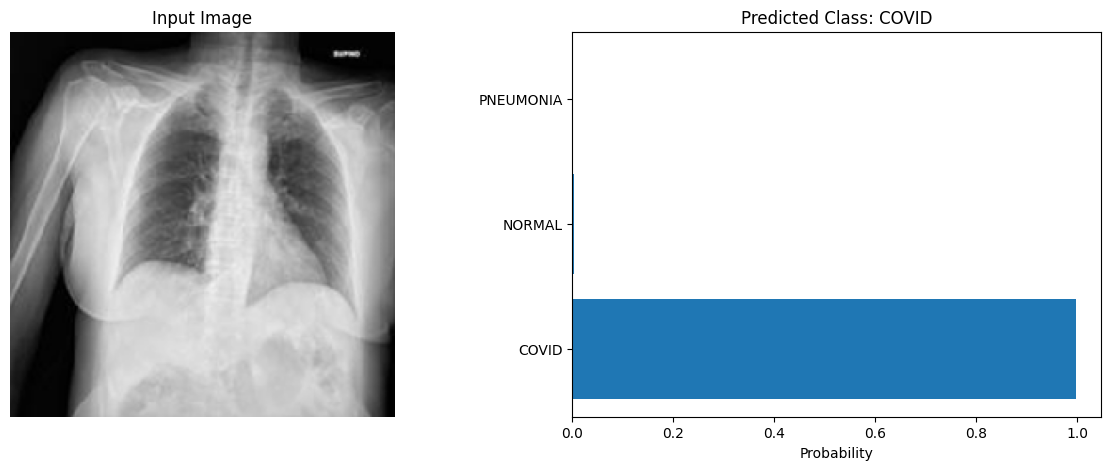

In [9]:
# 3. 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图像大小为模型输入大小
    transforms.ToTensor(),  # 将图像转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

image = Image.open(image_path)
input_image = transform(image)
input_image = input_image.unsqueeze(0)  # 增加一个维度作为批处理维度

# 4. 图像输入模型
net.eval()  # 设置模型为评估模式
with torch.no_grad():  # 禁用梯度计算
    input_image = input_image.to(device)
    output = net(input_image)
    
# 5. 处理模型输出
probabilities = F.softmax(output, dim=1)  # 使用softmax函数将输出转换为概率分布
probabilities = probabilities[0].cpu().numpy()  # 转换为numpy数组

# 6. 加载类别索引到类别名称的映射
class_indices_path = "class_indices.json"
assert os.path.exists(class_indices_path), "Cannot find {} file".format(class_indices_path)

with open(class_indices_path, "r") as f:
    class_indices = json.load(f)
    class_names = {int(idx): name for idx, name in class_indices.items()}

# 7. 获取每个类别的概率并展示
for i, prob in enumerate(probabilities):
    class_name = class_names.get(i, "Unknown")
    print("Class {}: {} - {:.2f}%".format(i, class_name, prob * 100))
    
# 8. 显示预测结果和图片
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 显示图片
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Input Image')

# 显示预测结果
predicted_class = torch.argmax(output).item()
predicted_class_name = class_names.get(predicted_class, "Unknown")
ax2.barh(range(len(probabilities)), probabilities)
ax2.set_yticks(range(len(probabilities)))
ax2.set_yticklabels([class_names.get(i, "Unknown") for i in range(len(probabilities))])
ax2.set_xlabel('Probability')
ax2.set_title('Predicted Class: {}'.format(predicted_class_name))

plt.show()